# Марковский процесс принятия решений

В данной работе рассматриваются методы, разработанные для решения Марковских процессов принятия решений, **M**arkov **D**ecision **P**rocesses, **MDP**. В самом широком смысле, MDP определяется тем, как он изменяет состояния и как вычисляются награды.

Переход состояний определяется распределением $P(s' |s,a)$ &mdash; насколько вероятно перейти в состояние $s'$, если производится действие $a$ в состоянии $s$. Существует несколько способов определить функцию вознаграждений, однако ради удобства будет использована следующая сигнатура: $r(s,a,s')$.

_Данный ноутбук вдохновлён заданием из курса_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _от Калифорнийского университета в Беркли_

Для начала, давайте определим простой MDP, изображённый на рисунке ниже:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Теперь можно использовать MDP как и другие среды от Open AI Gym:

In [2]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


но также есть и другие методы, необходимые для имплементации алгоритма итерацонной оптимизации ценности (Value Iteration)

In [3]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Опционально: визуализация MDP

Вы можете визуализировать MDP с помощью функции отрисовки, написанной [neer201](https://github.com/neer201).

Для этого требуется установить graphviz системно и для Python. На Unix-подобных системах (Ubuntu) для этого достатчно выполнить следующие команды:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. перезагрузить этот ноутбук

__Замечание:__ Установка graphviz на некоторые ОС (особенно Windows) может быть нетривиальной. Поэтому можно пропусить данный шаг и использовать стандартную визуализацию.

In [4]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz доступен:", has_graphviz)

Graphviz доступен: True


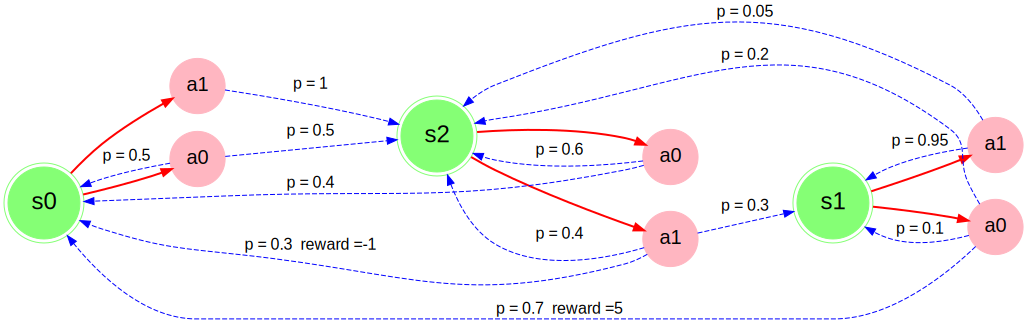

In [5]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, \
        plot_graph_optimal_strategy_and_state_values

    display(plot_graph(mdp))

# Итерационная оптимизация ценности, Value Iteration (вплоть до 4 баллов)

Теперь построим первый способ решения MDP. Простейший на данный момент алгоритм называется итерационной оптимизацией ценности или __V__alue __I__teration

Ниже представлен псевдокод VI:

---

`1.` Инициализация $V^{(0)}(s)=0$, for all $s$

`2.` Для $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Для начала выпишем функцию вычисления $Q$-функции ценности $Q^{\pi}$, определив следующим образом

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [6]:
%%writefile mdp_get_action_value.py
def get_action_value(mdp, state_values, state, action, gamma):
    """ Вычисляет Q(s,a) согласно формуле выше """

    # Ваша имплементация ниже
    if mdp.is_terminal(state):
        return 0.0
    q = 0.0
    for s, v in state_values.items():
        q += mdp.get_transition_prob(state, action, s) * (mdp.get_reward(state, action, s) + gamma * v)
    return q

Writing mdp_get_action_value.py


In [7]:
from mdp_get_action_value import *

In [8]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Используя $Q(s,a)$ можно определить "следующее" $V(s)$ для итерационной оптимизации ценности.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [9]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Вычисляет следующее V(s) согласно формуле выше. Просьба не изменять state_values в процессе. """
    if mdp.is_terminal(state):
        return 0

    # Ваша имплементация ниже
    q_vals = []
    for a in mdp.get_possible_actions(state):
        q_vals.append(get_action_value(mdp, state_values, state, a, gamma))
    return max(q_vals)

In [10]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert test_Vs == test_Vs_copy, "просьба не изменять state_values в get_new_state_value"

Наконец-то можно скомбинировать написанной в работающий алгоритм.

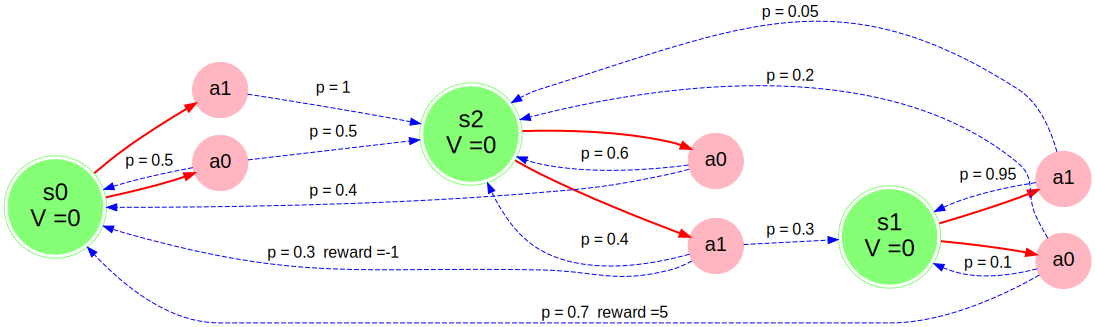

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.19277

In [11]:
%%time

# гиперпараметры
gamma = 0.9            # фактор дисконтирования MDP
num_iter = 100         # максимальное количество итераций, не включая инициализацию
# останов VI, если новые значения V(s) настолько близки к старым (или ближе)
min_difference = 0.001

# инициализация V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Вычисление новых V(s) используя определённые выше функции.
    # Должен быть словарь {state : float V_new(state)}
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Вычисление темпоральных различий V(s)
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Останов")
        break

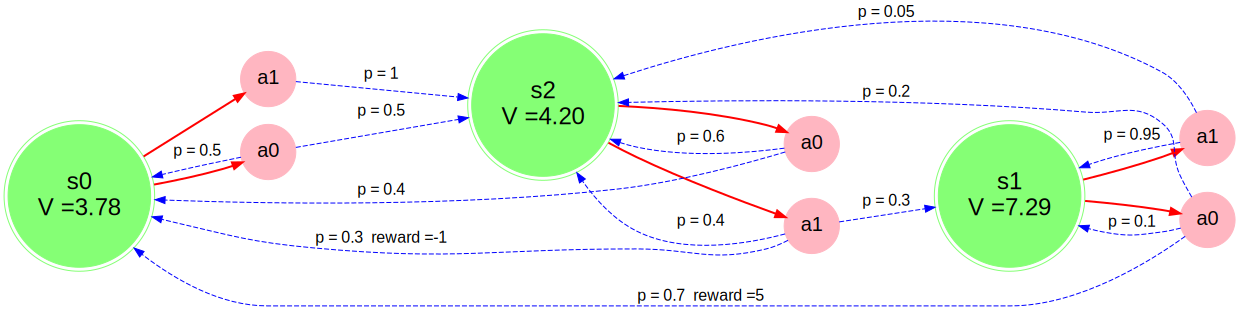

In [12]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [13]:
print("Финальные ценности состояний:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Финальные ценности состояний: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь используем полученные $V^{*}(s)$ для определения оптимальных действий в каждом состоянии

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
Единственной отличие по сравнению с вычислением `V(s)` состоит в извлечение не `max`, а `argmax`: поиск действия с максимальной ценностью `Q(s,a)`.

In [14]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Выбор оптимального действия, используя формулу выше. """
    if mdp.is_terminal(state):
        return None

    # Ваша имплементация ниже
    qa_list = []
    for a in mdp.get_possible_actions(state):
        qa_list.append((get_action_value(mdp, state_values, state, a, gamma), a))
    qa_list.sort(key=lambda t: -t[0])
    return qa_list[0][1]

In [15]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

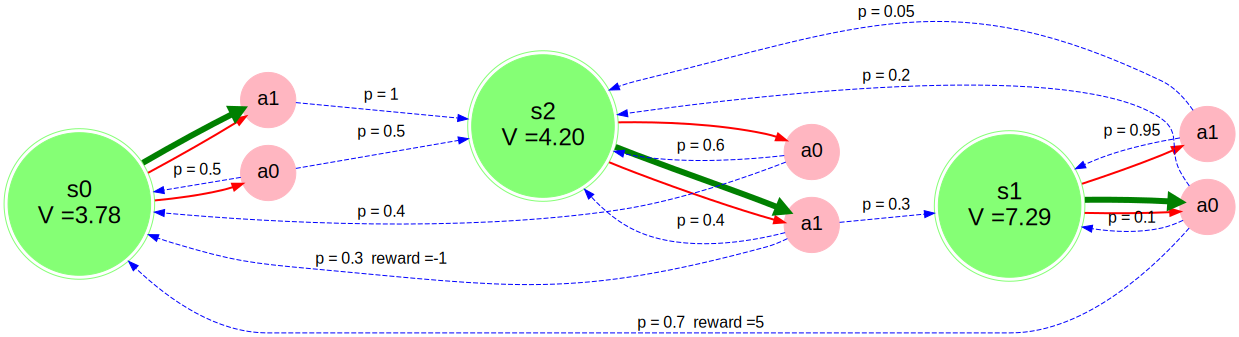

In [16]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError("Запустите ячейку, начинающуюся с \"%%writefile mdp_get_action_value.py\"")

In [17]:
%%time

# Оценка средней награды агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("средняя награда: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

средняя награда:  0.483
CPU times: user 594 ms, sys: 24.3 ms, total: 618 ms
Wall time: 617 ms


### Frozen lake

In [18]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [19]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5, verbose=True):
    """ Выполняет num_iter шагов итерационной оптимизации ценности, начиная с state_values.
         То же, что и ранее, но в формате функции """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Вычислить новые ценности состояний, используя определённые выше функции.
        # В результате должен получиться словарь формата {state : new_V(state)}
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

        assert isinstance(new_state_values, dict)

        # Вычислить темпоральную разность по значениям ценности
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())
        
        if verbose:
            print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f " %
                  (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [20]:
%%time

state_values = value_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
CPU times: user 9.5 ms, sys: 0 ns, total: 9.5 ms
Wall time: 9.43 ms


In [21]:
%%time

s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*

CPU times: user 5.11 ms, sys: 522 µs, total: 5.63 ms
Wall time: 5.14 ms


### Время визуализаций!

Обычно полезно и интересно видеть, что в действительности Ваш алгоритм выучивает под капотом. Для этого можно изобразить V-функцию и оптимальные действия на каждом шаге алгоритма VI.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 


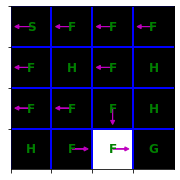

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 


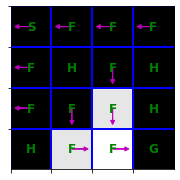

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 


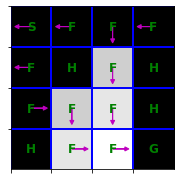

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 


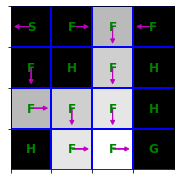

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 


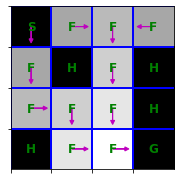

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 


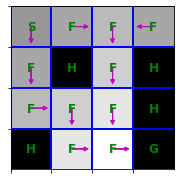

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


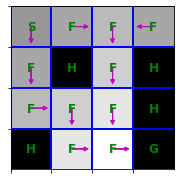

после итерации 7
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


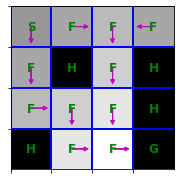

после итерации 8
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


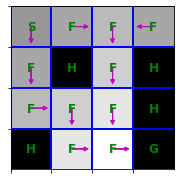

после итерации 9
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


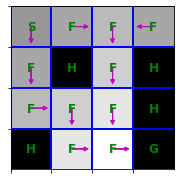

CPU times: user 1.45 s, sys: 1.63 s, total: 3.08 s
Wall time: 1.27 s


In [23]:
%%time

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 29
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.198 


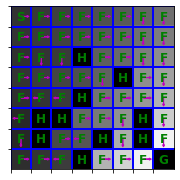

CPU times: user 9.88 s, sys: 3.46 s, total: 13.3 s
Wall time: 24.2 s


In [24]:
%%time

from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

Массовые испытания

In [25]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Отлинчая работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
средняя награда:  1.0
Отлинчая работа!
CPU times: user 1.11 s, sys: 5.94 ms, total: 1.11 s
Wall time: 1.1 s


In [26]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.62330   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.50487   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.40894   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.34868   |   V(start): 0.349 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06529   |   V(start): 0.410 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05832   |   V(start): 0.468 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.01139   |   V(start): 0.480 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.00764   |   V(start): 0.487 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00164   |   V(start): 0.489 
Итерация   11   |   разность max

In [27]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.75000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.50625   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.39867   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.26910   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.18164   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.14013   |   V(start): 0.140 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.07028   |   V(start): 0.199 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.06030   |   V(start): 0.260 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02594   |   V(start): 0.285 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01918   |   V(start): 0.305 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00858   |   V(start): 0.313 
Итерация   11   |   разность max

In [28]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.80000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.57600   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.41472   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.29860   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.24186   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.19349   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.15325   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.12288   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.09930   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.08037   |   V(start): 0.000 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.06426   |   V(start): 0.000 
Итерация   11   |   разность max

# Итерационная оптимизация политики, Policy Iteration (вплоть до 4 баллов)

Требуется имплементировать явную итерационную оптимизацию политики, Policy Iteration (PI) согласно следующему псевдокоду:

---
Иниуиализация $\pi_0$   `// случайная или константная`

Для $n=0, 1, 2, \dots$
- Вычислить функцию $V^{\pi_{n}}$
- С помощью $V^{\pi_{n}}$, вычислить функцию $Q^{\pi_{n}}$
- Вычислить новую политику $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

В отличие от VI, Policy Iteration требует явное вычисление политики &mdash; выбранное действие для каждого состояния &mdash; и оценку $V^{\pi_{n}}$ на основе данной политики. Обновление политики происходит после (итеративного) вычисления V-функции.


Ниже представлены несколько функций-помощников, которые могут оказаться полезными при имплементации методов.

In [29]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Настало время написать функцию под названием `compute_vpi`, которая вычисляет функцию $V^{\pi}$ для произвольной политики $\pi$.

В отличие от VI, в этот раз требуется точное решение, не просто одна итерация.

Напоминаем, что $V^{\pi}$ удовлетворяет следующему линейному соотношению:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Вам потребуется решить систему линейных алгебраических уравнений в коде. (Найдите точное решение, например, С помощью `np.linalg.solve` или метода простых итераций.)

In [30]:
def compute_vpi(mdp, policy, gamma):
    """
    Вычисляет V^pi(s) ДЛЯ ВСЕХ СОСТОЯНИЙ при текущей политике.
    :параметр policy: словарь выбранных на данный момент действий {s : a}
    :возвращает: словарь {state : V^pi(state) для всех state}
    """
    # Ваша имплементация ниже
    states = sorted(policy.keys())
    n_states = len(states)
    a = np.zeros((n_states, n_states))
    b = np.zeros((n_states, ))
    for i, s_old in enumerate(states):
        if mdp.is_terminal(s_old):
            a[i, i] = 1.0
            continue
        for j, s_new in enumerate(states):
            p = mdp.get_transition_prob(s_old, policy[s_old], s_new)
            r = mdp.get_reward(s_old, policy[s_old], s_new)
            a[i, j] = float(i == j) - gamma * p
            b[i] += p * r
    return {s: v for s, v in zip(states, np.linalg.solve(a, b))}

In [31]:
%%time

test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi должен возвращать словарь {state : V^pi(state) для всех state}"

{'s0': -0.7320493642483172, 's1': -0.27767389678384435, 's2': -0.8947270007479434}
CPU times: user 1.05 ms, sys: 238 µs, total: 1.29 ms
Wall time: 34.9 ms


Как только получены нове ценности состояний, время обновить текущую политику.

In [32]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Вычисляет жадно новую политику как argmax по функции ценности
    :параметр vpi: словарь {state : V^pi(state) для всех state}
    :возвращает: словарь {state : оптимальное действие для всех state}
    """
    return {s: get_optimal_action(mdp, vpi, s, gamma) for s in mdp.get_all_states()}

In [33]:
%%time

new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy должен возвращать словарь {состояние : оптимальное действие}"

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}
CPU times: user 413 µs, sys: 8 µs, total: 421 µs
Wall time: 391 µs


__Основной цикл__

In [34]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Запуск итерационной оптимизации политики в цикле на num_iter итераций или пока max_s|V_new(s) - V_old(s)|
    не станет меньше min_difference. Если начальная политика не дана, то инициализация случайная.
    """
    states = mdp.get_all_states()
    n_states = len(states)
    policy = policy or {s: np.random.choice(mdp.get_possible_actions(s)) if not mdp.is_terminal(s) else None\
                        for s in states}
    state_values = {s: 0.0 for s in states}
    for i in range(num_iter):
        new_state_values = compute_vpi(mdp, policy, gamma)
        new_policy = compute_new_policy(mdp, new_state_values, gamma)
        diff = max(abs(new_state_values[s] - state_values[s]) for s in states)
        print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))
        if len({k: new_policy[k] for k in new_policy if k in policy and new_policy[k] == policy[k]})\
            == n_states:
            state_values = new_state_values
            policy = new_policy
            break
        state_values = new_state_values
        policy = new_policy
    return state_values, policy

__Ваши результаты экспериментирования с PI__

Предложенный Вами MDP:

In [35]:
%%time

state_values, policy = policy_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.89473   |   V(start): -0.732 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 9.54540   |   V(start): 5.804 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 2.22765   |   V(start): 8.032 
CPU times: user 999 µs, sys: 227 µs, total: 1.23 ms
Wall time: 1.52 ms


Оценка средней награды агента на предложенном Вами MDP:

In [36]:
%%time

#Оценка средней награды агента

gamma = 0.9
s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("средняя награда: ", np.mean(rewards))

средняя награда:  0.894
CPU times: user 647 ms, sys: 3.45 ms, total: 650 ms
Wall time: 641 ms


Малое FrozenLake:

In [37]:
mdp = FrozenLakeEnv(slip_chance=0)

In [38]:
%%time

state_values, policy = policy_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): -0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): -0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): -0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): -0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
CPU times: user 17.6 ms, sys: 351 µs, total: 18 ms
Wall time: 17.3 ms


Средняя награда на малом FrozenLake:

In [39]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
средняя награда:  1.0
Отличная работа!
CPU times: user 1.16 s, sys: 3.01 ms, total: 1.16 s
Wall time: 1.16 s


In [40]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.62330   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.50487   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.40894   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.34868   |   V(start): 0.349 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06529   |   V(start): 0.410 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05832   |   V(start): 0.468 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.01139   |   V(start): 0.480 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.00764   |   V(start): 0.487 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00164   |   V(start): 0.489 
Итерация   11   |   разность max

In [41]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.75000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.50625   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.39867   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.26910   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.18164   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.14013   |   V(start): 0.140 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.07028   |   V(start): 0.199 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.06030   |   V(start): 0.260 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02594   |   V(start): 0.285 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01918   |   V(start): 0.305 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00858   |   V(start): 0.313 
Итерация   11   |   разность max

Средняя награда на большом FrozenLake:

In [42]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.80000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.57600   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.41472   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.29860   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.24186   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.19349   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.15325   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.12288   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.09930   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.08037   |   V(start): 0.000 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.06426   |   V(start): 0.000 
Итерация   11   |   разность max

На массовых тестах VI и PI показали сопоставимые результаты. Такое могло произойти из-за относительно малых масштабов рассмотренных сред.

# Поиск MDP, на котором Value Iteration работает достаточно долго (вплоть до 2 баллов)

Когда запускали Value Iteration на небольшой задаче frozen lake, последняя итерация, на которой изменялась стратегия обучаемой политики, была под номером 6 &mdash; то есть Value Iteration находил оптимальную политику на итерации 6. Существуют ли какие-либо гарантии на то, что в общем случае поиск оптимальной политики сверху ограничен конечным числом в MDP с негораниченным горизонтом с дисконтированием? Ответ без дополнительных предположений отрицательный, более того, можно предложить пример MDP, в котором жадный алгоритм оптимизации политики будет работать произвольное наперёд заданное заданное количество итераций.

Ваша задача: предъявить MDP с не более чем 3 состояниями и 2 действиями такой, что на нём алгоритм Value Iteration до останова требует, как минимум, 50 итераций. Используйте фактор дисконтирования, равный 0.95 (Однако, заметим, что величина дисконтирования тут не играет особой роли &mdash; в теории Вы можете предъявить MDP с произвольным дисконтированием, отвечающий требованиям выше.)

Замечание: V-функция ценности должна измениться хотя бы одни раз после 50-ой итерации (включая 50-ую итерацию), не требуется изменение V-функции на каждой итерации.

Функция для генерации случайного MDP:

In [43]:
def get_mdp():
    def get_probs():
        pv = np.zeros((3, ))
        pv[0] = np.random.randint(0, 11)
        pv[1] = np.random.randint(0, 11 - pv[0])
        pv[2] = 10 - pv.sum()
        return pv / pv.sum()
    
    def get_rewards(width=5):
        return np.random.randint(-width, width + 1, 3)
    
    transition_probs = {'s{}'.format(i): {'a{}'.format(j):\
                                          {'s{}'.format(k): p for k, p in enumerate(get_probs())}\
                                          for j in range(2)} for i in range(3)}
    rewards = {'s{}'.format(i): {'a{}'.format(j): {'s{}'.format(k): p for k, p in enumerate(get_rewards())}\
                                 for j in range(2)} for i in range(3)}
    
    return MDP(transition_probs, rewards, initial_state='s0'), transition_probs, rewards

Функция для поиска требуемого MDP:

In [44]:
def choose_mdps(n_samples=1000000, threshold=50):
    good_mdp_list = []
    gamma = 0.95
    
    for k in range(n_samples):
    
        mdp, tp, r = get_mdp()
        
        state_values = {s: 0 for s in mdp.get_all_states()}
        policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])
        
        total_n_changes = 0
        for i in range(100):
            state_values = value_iteration(mdp, state_values, num_iter=1, gamma=gamma, verbose=False)
            
            new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                                   for state in sorted(mdp.get_all_states())])
            
            n_changes = (policy != new_policy).sum()
            
            policy = new_policy
            if i > threshold:
                total_n_changes += int(n_changes > 0)
        
        if total_n_changes > 0:
            print('Нашли подходящий MDP, transition_probs:')
            print(tp)
            print('награды:')
            print(r)
            good_mdp_list.append((mdp, tp, r))
            return good_mdp_list
        
        #print('MDP сэмпл № {}, total_n_changes {}'.format(k, total_n_changes))
    return good_mdp_list

In [45]:
%%time

good_mdp_list = choose_mdps()

Нашли подходящий MDP, transition_probs:
{'s0': {'a0': {'s0': 0.6, 's1': 0.2, 's2': 0.2}, 'a1': {'s0': 1.0, 's1': 0.0, 's2': 0.0}}, 's1': {'a0': {'s0': 0.8, 's1': 0.0, 's2': 0.2}, 'a1': {'s0': 0.8, 's1': 0.2, 's2': 0.0}}, 's2': {'a0': {'s0': 0.8, 's1': 0.1, 's2': 0.1}, 'a1': {'s0': 0.8, 's1': 0.1, 's2': 0.1}}}
награды:
{'s0': {'a0': {'s0': -4, 's1': -3, 's2': -1}, 'a1': {'s0': 2, 's1': -5, 's2': -4}}, 's1': {'a0': {'s0': -4, 's1': -5, 's2': 4}, 'a1': {'s0': -5, 's1': 0, 's2': -1}}, 's2': {'a0': {'s0': 4, 's1': 1, 's2': 4}, 'a1': {'s0': 5, 's1': 1, 's2': -4}}}
CPU times: user 7.38 s, sys: 2.6 ms, total: 7.38 s
Wall time: 7.39 s


In [46]:
transition_probs = good_mdp_list[0][1]
rewards = good_mdp_list[0][2]

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state='s0')
# Не бойтесь изменять начальное состояние initial_state

In [47]:
%%time

gamma = 0.95
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1, gamma=gamma)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("Количество поменявшихся действий = %i \n" % n_changes)
    policy = new_policy

# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 3.70000   |   V(start): 2.000 
Количество поменявшихся действий = 0 

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 2.22300   |   V(start): 3.900 
Количество поменявшихся действий = 0 

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.81132   |   V(start): 5.705 
Количество поменявшихся действий = 0 

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.71595   |   V(start): 7.420 
Количество поменявшихся действий = 0 

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.62901   |   V(start): 9.049 
Количество поменявшихся действий = 0 

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.54756   |   V(start): 10.596 
Количество поменявшихся действий = 1 

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.47018   |   V(start): 12.067 
Количество поменявшихся дейст